In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

# Importing Data

In [2]:
# Loading the dataset
selected_basins = gpd.read_file('Outputs/Final_selected_basins.shp')
selected_basins.shape

land_use = gpd.read_file('GIS_manipulation/Clipping_land_use/land_use_selected_basins_28992.shp')
land_use.shape

(1512, 6)

In [3]:
land_use_cat = land_use.dissolve(by='Code_18')
land_use_cat.shape

(29, 5)

In [4]:
land_use_cat.reset_index(inplace=True)
land_use_cat.dtypes

Code_18       object
geometry    geometry
OBJECTID     float64
Remark        object
Area_Ha      float64
ID            object
dtype: object

# Dissoving similar land uses

In [5]:
import regex

land_use_cat['category'] = land_use_cat['Code_18']
categories = ['A','B', 'C','D','E']
values = [1, 2, 3, 4, 5]
for i,j in zip(categories, values):
    land_use_cat['category'].replace(str(j)+'\d{2}', i,regex=True, inplace = True)
land_use_cat_dis = land_use_cat.dissolve(by='category')
land_use_cat_dis.reset_index(inplace=True)
land_use_cat_dis

,category,geometry,Code_18,OBJECTID,Remark,Area_Ha,ID
0,A,"MULTIPOLYGON (((125254.289 388882.660, 125332....",112,1572159.0,None,150.09128,EU_1572159
1,B,"MULTIPOLYGON (((170587.238 371203.235, 170451....",211,1587381.0,None,15546.45780,EU_1587381
2,C,"MULTIPOLYGON (((164282.063 375013.884, 164290....",311,1605216.0,None,46.70077,EU_1605216
3,D,"MULTIPOLYGON (((67385.794 393660.053, 67405.51...",411,1623324.0,None,36.66414,EU_1623324
4,E,"MULTIPOLYGON (((72242.443 391882.397, 72318.84...",511,1624911.0,None,1786.50020,EU_1624911


<AxesSubplot:>

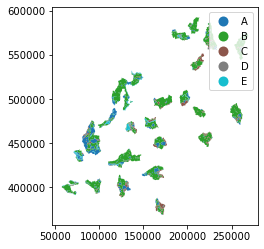

In [6]:
land_use_cat_dis.plot(column='category', categorical=True, legend=True)

In [7]:
selected_basins = selected_basins[['HYBAS_ID', 'geometry']]
selected_basins.columns
selected_basins.reset_index(drop=True, inplace=True)
selected_basins.head()

,HYBAS_ID,geometry
0,2120023210,"MULTIPOLYGON (((5.09861 52.44583, 5.09105 52.4..."
1,2121116060,"POLYGON ((4.96250 51.78750, 4.94758 51.78785, ..."
2,2120370440,"POLYGON ((5.37917 52.19167, 5.37860 52.19388, ..."
3,2120371920,"POLYGON ((5.03750 52.22083, 5.03418 52.22168, ..."
4,2120380390,"POLYGON ((4.52083 51.91667, 4.51752 51.91752, ..."


In [8]:
# loop categories
dicts = {}
cat_names = ['A', 'B', 'C', 'D', 'E']

for key in cat_names:
    value = land_use_cat_dis.loc[land_use_cat_dis.category==key]
    value = value.to_crs(epsg='28992')
    dicts[key] = value

In [9]:
cat_2d_table = np.zeros((selected_basins.shape[0],6))
for idx, i in enumerate(selected_basins.iterrows()):
    gdf_i = gpd.GeoDataFrame(pd.DataFrame(i[1:], columns =selected_basins.columns))
    gdf_i.set_crs(epsg=28992, inplace=True)
    # adding a loop for the five different land-use categories
    for number, key in enumerate(cat_names):
        area = gpd.clip(dicts[key], gdf_i).area.values
        cat_2d_table[idx, number] = area[0] if area.size != 0 else 0
    cat_2d_table[idx, 5] = gdf_i.HYBAS_ID

# Estimating the percentages of different land uses

In [10]:
cat_2d_table_df = pd.DataFrame(cat_2d_table, columns=['cat_A', 'cat_B', 'cat_C', 'cat_D', 'cat_E', 'HYBAS_ID'])
selected_basins.to_crs(epsg=28992, inplace=True)
cat_2d_table_df['area'] = selected_basins['geometry'].area

percent_names = ['perc_cat_A', 'perc_cat_B', 'perc_cat_C', 'perc_cat_D', 'perc_cat_E']
for i,j in zip(cat_2d_table_df.columns[:-2], percent_names):
    cat_2d_table_df[j] = cat_2d_table_df[i] / cat_2d_table_df.area
cat_2d_table_df.drop(['cat_A', 'cat_B', 'cat_C', 'cat_D', 'cat_E'], axis=1, inplace=True)
cat_2d_table_df['HYBAS_ID'] = cat_2d_table_df.HYBAS_ID.astype('int').astype('str');

In [11]:
cat_2d_table_df.head(3)

,HYBAS_ID,area,perc_cat_A,perc_cat_B,perc_cat_C,perc_cat_D,perc_cat_E
0,2120023210,2.878610e+08,0.0,0.0,0.0,0.0,0.0
1,2121116060,1.310451e+08,0.0,0.0,0.0,0.0,0.0
2,2120370440,1.424148e+08,0.0,0.0,0.0,0.0,0.0
